In [1]:
import import_ipynb
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import time as timer

In [ ]:
def OR_gate(bn, x, ylist): 
    # x: child
    # yDlist : parents
    #
    def p2table1(p):
        v = np.zeros(2)
        v[:] = [1-p,p]
        return v

    def p2table2(p):
        v = np.zeros((2,2))
        v[0,:] = [1,0]
        v[1,:] = [1-p,p]
        return v   

    
    
    bn.add(x, 2)
    #bn.cpt(bn.idFromName(x))[:] = p2table1(0.1)
    
        
    def makecpds1(bn, x,ylist):
        u = np.zeros((2,2))
        u[0,:] = [1,0]
        u[1,:] = [0,1]

        my_arc_list = ''
        my_node_list = list()
        x0 = x
        print(ylist[0])
        bn.addArc(bn.idFromName(ylist[0]),bn.idFromName(x0))
        bn.cpt(bn.idFromName(x0))[:] = u
        return  bn

    def makecpds2(bn, x,ylist):
        u = np.zeros((2,2,2))
        u[0,0,:] = [1,0]
        u[0,1,:] = [0,1]
        u[1,0,:] = [0,1]
        u[1,1,:] = [0,1]
        my_arc_list = ''
        my_node_list = list()
        x0 = x
        for i, y in enumerate(ylist[:-2]):
            z = 'Coparent('+str(y)+')->'+x     # hulp knoop, coparent van y in OR die wijst naar x
            my_node_list += [z]
            bn.add(z, 2)
            my_arc_list += x0+'<-'+y+';'
            my_arc_list += x0+'<-'+z+';'
            bn.addArc(bn.idFromName(y),bn.idFromName(x0))
            bn.addArc(bn.idFromName(z),bn.idFromName(x0))
            bn.cpt(bn.idFromName(x0))[:] = u
            x0 = z
        y = ylist[-2]    
        z = ylist[-1]
        my_arc_list += x0+'<-'+y+';'
        my_arc_list += x0+'<-'+z+';'
        bn.addArc(bn.idFromName(y),bn.idFromName(x0))
        bn.addArc(bn.idFromName(z),bn.idFromName(x0))
        bn.cpt(bn.idFromName(x0))[:] = u
        return  bn

    def makecpds(bn, x,ylist):
        if(len(ylist)>=2):
            bn = makecpds2(bn, x,ylist)
        elif(len(ylist)==1):
            print(ylist)
            bn = makecpds1(bn, x,ylist)
        return bn
    
    bn =  makecpds(bn, x, ylist)
                
    return bn

In [ ]:
def create_noisy_or():
    """
    Creates a noisy_or network with diagnosis and tests. They can be filled in manually
    """
    # Create a list diagnoses
    diags = [chr(i) for i in range(ord('a'), ord('a')+3)]
    # Create an empty dictionary to store the random values
    prior = {}

    # Loop through each letter in the list and add a random value to the dictionary
    for d in diags:
        prior[d] = np.random.uniform(0, 0.1)
        
    tests = ['x', 'y']
    sens= {}
    for t in tests:
        sens[t] = {}
        for d in diags:
            sens[t][d] = np.random.uniform(0, 0.1)
    bnNOR=gum.BayesNet('noisy-OR network')
    for d in diags:
        bnNOR.add(gum.LabelizedVariable(d,d,2))
        bnNOR.cpt(d).fillWith([1-prior[d],prior[d]])
        for t in tests:
            u = np.zeros((2,2))
            u[0,:] = [1,0]
            u[1,:] = [1-sens[t][d],sens[t][d]]
            bnNOR.add(gum.LabelizedVariable(t+d,t+d,2))
            bnNOR.addArc(bnNOR.idFromName(d),bnNOR.idFromName(t+d))
            bnNOR.cpt(t+d)[:] = u
    
    for t in tests:
        bnNOR = OR_gate(bnNOR, t, [t+d for d in diags])
    return bnNOR

In [ ]:
bn = create_noisy_or()
bn
pred = create_noisy_or()
pred

In [4]:
def generate_truth_table(num_inputs):
    """
    Generates a combination of 0's and 1's depending on the number of inputs.
    An input of 4 would result in an array [00, 10, 01, 11].
    """
    table = []
    for i in range(2**num_inputs):
        row = []
        for j in range(num_inputs):
            row.append((i // 2**j) % 2)
        table.append(row)
    return table

def get_theta(bn):
    """Gets all the theta's from a bayesian network

    Args:
        bn (_type_): a bayesian network

    Returns:
        theta: all theta's from a bayesian network
    """
    theta = []
    for var in sorted(bn.names()):
        parents = sorted(bn.parents(var))
        if len(parents) == 0:
            dic = {}
            dic[var] = 1
            theta.append(dic)
        else:
            elems = generate_truth_table(len(parents))
            for combination in elems:
                dic = {}
                dic[var] = 1
                for value in range(len(combination)):
                    parent = list(bn.parents(var))[value]
                    name = bn.variable(parent).name()
                    dic[name] = combination[value]
                theta.append(dic)
    return theta

def get_parameters(bn):
    """
    Gets the parameters out of a Bayesian Network and returns them as an array
    """
    parameters = []
    names = sorted(bn.names())
    for name in names:
        prob = bn.cpt(name).toarray().flatten()
        if len(prob) == 2:
            parameters.append(prob[1])
        else:
            for i in range(len(prob)):
                if i % 2 != 0:
                    parameters.append(prob[i])
    parameters = np.array(parameters)
    return parameters

def calculate_posterior(bn, posterior, evidence = {}):
    """
    Calculates the posterior probability of a variable in a Bayesian Network. The default is without evidence, 
    but can be added if this is needed
    """
    ie = gum.LazyPropagation(bn)
    ie.setEvidence(evidence)
    post = ie.posterior(posterior)
    prob = np.array([post[0], post[1]])
    return prob[1]   


def set_cpt(bn, probabilities):
    """
    Given a Bayesian Network and an array of probabilities, this function will update the cpt of the Bayesian Network based 
    on the array. 
    Variables will be traversed alphabetically
    """
    variables = sorted(bn.names())
    current = 0
    for i in range(len(variables)):
        node = variables[i]
        parents = bn.parents(node)
        if not parents:
            bn.cpt(node).fillWith([1-probabilities[current], probabilities[current]])
            current += 1
        else:
            length = len(parents)
            elements = pow(2,length)
            probs = []
            for j in range(current, current+elements):
                if j < 4:
                    
                    if not(probabilities[j] == 0 or probabilities[j] == 1):
                        probs.append(1-probabilities[j])
                        probs.append(probabilities[j])
                current += 1
            bn.cpt(node).fillWith(np.array(probs))
    return bn  


def reversed_prob(bn):
    """
    Gets all the reversed probabilities in a network and puts them in a dictionary. Reversed probabilities are
    P(Parent|Child). 
    """
    probs = {}
    for name in bn.names():
        if len(bn.parents(name)) > 0:
            for parent in bn.parents(name):
                current = bn.variable(parent).name()
                tup = (current, 1, name, 0)
                probs[tup] = calculate_posterior(bn, current, {name:0})
                tup = (current, 1, name, 1)
                probs[tup] = calculate_posterior(bn, current, {name:1})
    return probs

def show_losses(loss, iterations):
    """
    This function takes an array of losses and plots them for every iteration
    """
    plt.plot(np.arange(0,iterations), loss)

In [3]:
def get_parameters_noisy(bn):
    """Gets all parameters from a bayesian network

    Args:
        bn (_type_): a bayesian network

    Returns:
        parameters: an array of probabilities
    """
    param = []
    root = []
    for var in sorted(bn.names()):
        parent = sorted(bn.parents(var))
        if len(parent) == 0:
            root.append(var)
            
    for var in sorted(bn.names()):
        parent = sorted(bn.parents(var))
        
        prob = bn.cpt(var).toarray().flatten()
        if len(prob) == 2:
            param.append(prob[1])
        else:
            name = bn.variable(parent[0]).name()
            if name in root:
                
                param.append(prob[3])
                
    parameters = np.array(param)
    return parameters

def get_theta_noisy(bn):
    """Gets all theta's from a bayesian network

    Args:
        bn (_type_): a bayesian network

    Returns:
        theta: all parameters of a bayesian network
    """
    theta = []
    root = []
    for var in sorted(bn.names()):
        parent = sorted(bn.parents(var))
        if len(parent) == 0:
            dic = {}
            dic[var] = 1
            theta.append(dic)
            root.append(var)
    for var in sorted(bn.names()):
        parent = sorted(bn.parents(var))
        
        if len(parent) > 0:
            name = bn.variable(parent[0]).name()
            if name in root:
                dic = {}
                dic[var] = 1
                dic[name] = 1
                theta.append(dic)
    return theta

def set_cpt_noisy(bn, probabilities):
    """
    Given a Bayesian Network and an array of probabilities, this function will update the cpt of the noisy-or Bayesian Network based 
    on the array. 
    Variables will be traversed alphabetically
    """
    root = []
    for var in sorted(bn.names()):
        if len(bn.parents(var)) == 0:
            root.append(var)
            
    
    variables = sorted(bn.names())
    current = 0
    for i in range(len(variables)):
        node = variables[i]
        parents = sorted(bn.parents(node))
        if not parents:
            bn.cpt(node).fillWith([1-probabilities[current], probabilities[current]])
            current += 1
        else:
            name = bn.variable(parents[0]).name()
            if name in root:
                bn.cpt(node)[{name:1}] = [1-probabilities[current], probabilities[current]]
                current += 1
    return bn  

In [493]:
def check(I, clammed):
    """
    Checks if the value at the clammed spot and the instantiation of the complete joint probability are the same for all variables
    """
    for x in clammed:
        if I[x] != clammed[x]:
                return False
    return True

def remove_first_key(my_dict):
    """
    Removes the first key and value pair of a dictionary and returns this first key and a new dict without this first one
    """
    keys = list(my_dict.keys())
    
    first = keys.pop(0)
    
    new_dict = {key: my_dict[key] for key in keys}
    
    return first, new_dict

def add_lists(list1, list2):
    """
    Adds two lists together element-wise.
    Assumes both lists are of equal length.
    """
    return [x + y for x, y in zip(list1, list2)]

def tuple_to_dict(t):
    """Converts a tuple of alternating key-value pairs to a dictionary."""
    d = {}
    for i in range(0, len(t), 2):
        key = t[i]
        value = t[i+1]
        d[key] = value
    return d
def dict_to_tuple(d):
    """Converts a dictionary to a tuple of alternating key-value pairs."""
    t = tuple(d.items())
    return sum(t, ())       

In [524]:
def gradient(bn, I, theta, first):
    """
    Calculates the gradient of a probability with respect to theta
    """
    if len(theta) == 1:
        if I[first] == 0:
            return -1
        else:
            return 1
    else: 
        parents = bn.parents(first)
        derivative = []
        to = []
        for i in parents:
            name = bn.variable(i).name()
            derivative.append(I[name])
            to.append(theta[name])
        if I[first] == 0:
            if derivative == to:
                return -1
            else:
                return 0
        else:
            if derivative == to:
                return 1
            else:
                return 0
                
    
def gamma(bn, I, theta): 
    """
    Calculates the gamma part of the article
    """
    length = len(list(theta.keys()))
    p = 0
    first2, new = remove_first_key(theta)
    p = calculate_posterior(bn, first2, new)
    if not check(I,theta):
        p = 1 - p
    first = 0
    if p > 0:
        first = np.divide(1, p)
    else:
        first = np.divide(1,0.000000000000000000001)
    second = gradient(bn,I,theta, first2, new)
    total = first * second
    return total

def gradient_cpt(bn, clammed, theta):
    """
    Calculates the gradient of the cpt according to the article
    bn = bayesian network
    clammed = dictionary of clammed variables and their values
    """
    s = 0
    I = bn.completeInstantiation()
    for i in range (pow(2,len(bn.names()))):
        prob = 0
        g = 0
        if check(I, clammed):
            prob = bn.jointProbability(I)
            g = gamma(bn, I, theta)
            total = prob * g

            s += total
        I.inc()

    return s

def gradient_probability(bn, probabilities, theta):
    """
    Calculates the gradient of the probabilities with respect to theta according to the article
    """
    keys = list(probabilities.keys())
    first = keys[0]
    second = keys[1]
    ie = gum.LazyPropagation(bn)
    post = ie.posterior(second)
    c = 0
    x = 0
    if probabilities[second] == 0:
        c = post[0]
        
    else:
        c = post[1]
        
    if probabilities[first] == 1:
        x = calculate_posterior(bn, first, remove_first_key(probabilities)[1])
    else: 
        x = 1 - calculate_posterior(bn, first, remove_first_key(probabilities)[1])

    grad1 = gradient_cpt(bn, probabilities, theta)
    grad2 = gradient_cpt(bn, remove_first_key(probabilities)[1], theta)

    total = np.divide(1, c) * (grad1 - x * grad2)

    return total

def gradient_loss(bn, probabilities, y_true, y_pred, theta):
    """
    Calculates the gradient of the loss with respect to theta, according to the article
    """

    loss = -2 * y_true[probabilities] + 2 * y_pred[probabilities]
    probabilities = tuple_to_dict(probabilities)
    grad = gradient_probability(bn, probabilities, theta)
    total = loss * grad
    return total

In [525]:
def sse(dict1, dict2):
    """
    Computes the sum of squared errors between two arrays.

    Args:
        arr1 (numpy array): The first array.
        arr2 (numpy array): The second array.

    Returns:
        float: The sum of squared errors between arr1 and arr2.
    """
    arr1 = np.array(list(dict1.values()))
    arr2 = np.array(list(dict2.values()))
    sse = np.sum((arr1 - arr2) ** 2)
    return sse

In [526]:
def gradient_descent(pred, y_true, y_pred):
    """
    Performs gradient descent on a given prediction network
    """
    theta_pred = get_parameters_noisy(pred)
    theta = get_theta_noisy(pred)

    start_time = timer.time()
    losses = []
    j=0
    iterations = 10000
    previous = []
    lr = 0.1
    for j in range(iterations):
        s = np.zeros(len(theta))
        for i in y_true:
            grads = []
            for x in theta:
                grad = gradient_loss(pred, i, y_true, y_pred, x)
                grads.append(grad)
            s = add_lists(s,grads)
        new_list = [x * lr for x in s]
   
        theta_pred = theta_pred - new_list
        for i in range(len(theta_pred)):
            if theta_pred[i] > 1:
                theta_pred[i] = 1
            elif theta_pred[i] < 0:
                theta_pred[i] = 0
        loss = sse(y_true, y_pred)
        losses.append(loss)
        pred = set_cpt_noisy(pred, theta_pred)
        y_pred = {('a', 1, 'x', 1): calculate_posterior(pred, 'a', {"x":1})}
        j += 1
        if j % 100 == 0:
            print(j)
            print(theta_pred)
            print(y_pred )
        if np.array_equal(previous, y_pred) or np.array_equal(previous, y_true):
            print("Nr of iterations:", j)
            end_time = timer.time()
            t = end_time - start_time
            return theta_pred, y_pred, j, t, losses
        previous = y_pred
    return theta_pred, y_pred, j, start_time, losses

In [527]:
def run_algorithm(bn,pred):
    """
    Runs the complete algorithm. Only a run of the initialization of the Bayesian Networks is needed before this
    """
    true = {('a', 1, 'x', 1): calculate_posterior(bn, 'a', {"x":1})}
    pred2 = {('a', 1, 'x', 1): calculate_posterior(pred, 'a', {"x":1})}
    t, y, j, tim, loss = gradient_descent(pred, true, pred2)
    return t, y, j, tim, loss

In [530]:
true = {('a', 1, 'x', 1): calculate_posterior(bn, 'a', {"x":1})}
pred2 = {('a', 1, 'x', 1): calculate_posterior(pred, 'a', {"x":1})}
print(true)
print(pred2)

{('a', 1, 'x', 1): 0.14725194447095963}
{('a', 1, 'x', 1): 0.14725194706388148}


In [529]:
t, y, j, tim, loss = run_algorithm(bn,pred)
print(t, y, j)
print(tim, "seconds")

KeyboardInterrupt: 

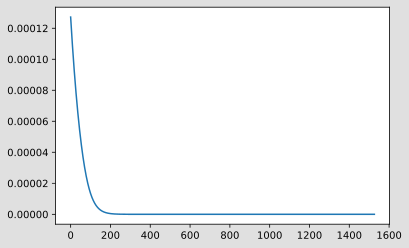

In [521]:
show_losses(loss, j)

[0.07752621 0.18229397 0.06482357 0.03997309 0.17739558 0.06661029
 0.02141958 0.0052194  0.0077496 ]


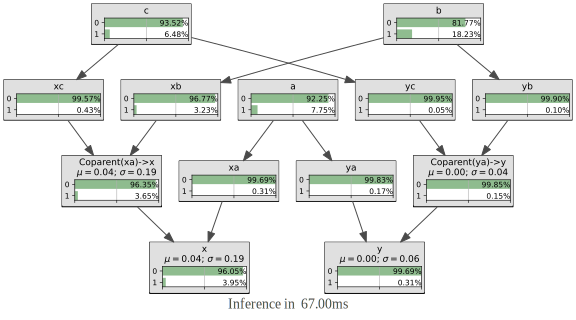

In [531]:
print(get_parameters(pred))
gnb.showInference(pred)

[0.01810474 0.03088913 0.         1.         1.         1.
 0.         0.06707303 0.         0.06416724]


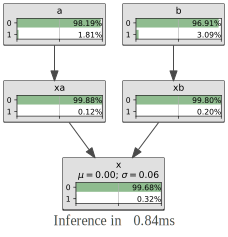

In [436]:
print(get_parameters(bn))
gnb.showInference(bn)